In [2]:
import os
import re
import numpy as np
import pandas as pd
import sklearn
from sklearn.utils import shuffle

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')


from scipy.sparse import csr_matrix
from collections import Counter
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.utils import class_weight

#!pip install emoji
import emoji


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/saumyamehta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/saumyamehta/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
olid_data = pd.read_csv("data/OLIDv1/olid-training-v1.0.tsv", sep='\t')


Emoji to text conversion

In [5]:
def emoji_to_text(s):
    s = emoji.demojize(s)
    s = s.replace(':',' ')
    s = s.replace('_',' ')    
    s = ' '.join(s.split())
    return s

In [6]:
# small sentence demo for emoji to text
s = '@USER He is all grown up😭😭😭'
emoji_to_text(s)

'@USER He is all grown up loudly crying face loudly crying face loudly crying face'

Twitter slang to formal text conversion

In [7]:
# loading twitter slang data
slang_df = pd.read_csv('data/twitterSlang.csv')
slang_dict = dict(zip(slang_df.slang, slang_df.formal_translation))


In [8]:
def fix_slang(s):
    s_list = s.split()
    new_s_list = []
    for word in s_list:
        if word in slang_dict.keys():
            new_s_list.append(slang_dict[word])
        else:
            new_s_list.append(word)
            
    return ' '.join(new_s_list)

In [9]:
# small example of slang removal
s = "I'll fix this asap. brb"
fix_slang(s)

"I'll fix this asap. be right back"

In [10]:
def preprocess(sent, lemmatizer, stop_words):
    
    alphabet = "abcdefghijklmnopqrstuvwxyz 0123456789',."
    sent = emoji_to_text(sent)
    sent = fix_slang(sent)
    sent = sent.lower()
    sent = sent.replace('@user','')
    sent = sent.replace('@[\w\-]+','')

    cleaned_sent_list = [char if char in alphabet else ' ' for char in sent] # remove all tags not in the alphabet

    cleaned_sent = ''.join(cleaned_sent_list)
    cleaned_sent_list = [lemmatizer.lemmatize(token) for token in cleaned_sent.split(" ")]
    cleaned_sent_list = [word for word in cleaned_sent_list if not word in stop_words]
    cleaned_sent = ' '.join(cleaned_sent_list)
    cleaned_sent = cleaned_sent.replace("n't",' not') # replace words like "isn't" with "is not"
    cleaned_sent = ' . '.join([x for x in cleaned_sent.split('.') if len(x)>0]) # remove multiple periods, and add spaces before and after a period
    cleaned_sent = ' , '.join([x for x in cleaned_sent.split(',') if len(x)>0]) # add spaces before and after a comma
    cleaned_sent = ' '.join(cleaned_sent.split()) # remove multiple spaces
    
    return cleaned_sent

In [11]:
X_train = olid_data.tweet
y_train = pd.factorize(olid_data.subtask_a)[0]

X_test=pd.read_csv('data/OLIDv1/testset-levela.tsv',sep="\t").tweet
y_test=pd.read_csv( 'data/OLIDv1/labels-levela.csv',header=None).iloc[:,-1]
y_test = pd.factorize(y_test)[0]
import collections
collections.Counter(y_train)
print(f'X train shape: {X_train.shape}, y train shape: {y_train.shape}')


X train shape: (13240,), y train shape: (13240,)


Splitting data into train, test and hold out sets.
Our split will be 80% train, 10% validation and 10% test

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train,test_size=0.2, random_state=42)
# check shapes of train, test and validation data
print(f'X train shape: {X_train.shape}, y train shape: {y_train.shape}')
print(f'X valid shape: {X_valid.shape}, y valid shape: {y_valid.shape}')
print(f'X valid shape: {X_test.shape}, y test shape: {y_test.shape}')


X train shape: (10592,), y train shape: (10592,)
X valid shape: (2648,), y valid shape: (2648,)
X valid shape: (860,), y test shape: (860,)


Data preprocessing. 

In [13]:

stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer()
data_train = [preprocess(tweet,lemmatizer,stop_words) for tweet in X_train]
data_valid = [preprocess(tweet,lemmatizer,stop_words) for tweet in X_valid]
data_test = [preprocess(tweet,lemmatizer,stop_words) for tweet in X_test]

In [14]:
data_train[0], data_valid[0], data_test[0]

('leaving bb',
 'john kerry running mouth cared ha say think single damn thing kerry ha accomplished besides run mouth . trump accomplishment exceed anything kerry could ever dream of . even becoming president',
 'whoisq wherestheserver dumpnike declasfisa democrat support antifa , muslim brotherhood , ms13 , isis , pedophilia , child trafficking , taxpayer funded abortion s , election fraud , sedition treason lockthemallup wwg1wga qanon url')

Create a vocabulary with UNK token for out of vocabulary words

In [3]:
vocab_size = 10000
embedding_size = 100
lstm_output_dim = 32
max_length = 200
trunc_type='post'
padding_type='post'
oov_tok = "<UNK>"

Tokenisation and padding for sentences


In [16]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(data_train)


In [17]:
train_sequences = tokenizer.texts_to_sequences(data_train)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

valid_sequences = tokenizer.texts_to_sequences(data_valid)
valid_padded = pad_sequences(valid_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)



# Building the model

RNN architecture: Embedding layer of size 100 -> lstm layer with output of 32 dimension -> linear layer activated by relu -> softmax to get probability 

In [4]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=vocab_size,output_dim=embedding_size,input_length=max_length))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences = True)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(30, return_sequences = True)))
model.add(tf.keras.layers.GlobalMaxPool1D())
model.add(tf.keras.layers.Dense(100, activation="relu"))
model.add(tf.keras.layers.Dense(20, activation="relu"))
model.add(tf.keras.layers.Dropout(0.05))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 100)          1000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 200, 128)          63744     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 60)           28800     
_________________________________________________________________
global_max_pooling1d (Global (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 100)               6100      
_________________________________________________________________
dense_1 (Dense)              (None, 20)                2020      
_________________________________________________________________
dropout (Dropout)            (None, 20)                0

In [19]:
# compute class weights : "https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html"
class_weights = class_weight.compute_class_weight(
    class_weight = 'balanced',
    classes = np.unique(y_train),
    y = y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))
class_weights


{0: 1.5196556671449069, 1: 0.7451808076544252}

In [20]:
# Training loop and early stopping 

callbacks = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",mode="auto", patience=5,restore_best_weights=True )
n_epochs = 25

In [21]:
model_trained = model.fit(train_padded, y_train, batch_size=128, epochs = n_epochs, 
verbose=2, class_weight=class_weights,validation_data=(valid_padded, y_valid), callbacks = [callbacks])

2021-12-08 12:27:10.907131: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-08 12:27:10.907320: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
Epoch 1/25
83/83 - 24s - loss: 0.6562 - accuracy: 0.6148 - val_loss: 0.5716 - val_accuracy: 0.7168
Epoch 2/25
83/83 - 20s - loss: 0.4611 - accuracy: 0.7900 - val_loss: 0.5355 - val_accuracy: 0.7424
Epoch 3/25
83/83 - 20s - loss: 0.3130 - accuracy: 0.8765 - val_loss: 0.6090 - val_accuracy: 0.7364
Epoch 4/25
83/83 - 20s - loss: 0.2215 - accuracy: 0.9212 - val_loss: 0.6740 - val_accuracy: 0.7330
Epoch 5/25
83/83 - 20s - loss: 0.1568 - accuracy: 0.9461 - val_loss: 0.9158 - val_accuracy: 0.7066
Epoch 6/25
83/83 - 20s - loss: 0.1145 - accuracy: 0.9597 - val_loss: 1.0193 - val_accuracy: 0.7224
Epoch 7/25
83/83 - 21s - loss: 0.0855 - accuracy: 0.9713 - val_loss: 1.1309 - val_accuracy: 0.7062


In [25]:
model_trained.history

{'loss': [0.6561611890792847,
  0.4611322283744812,
  0.3130303919315338,
  0.2214677929878235,
  0.15684238076210022,
  0.11445705592632294,
  0.08548987656831741],
 'accuracy': [0.6148036122322083,
  0.7900302410125732,
  0.8765105605125427,
  0.9211668968200684,
  0.9460914134979248,
  0.9596865773200989,
  0.9712991118431091],
 'val_loss': [0.5716100335121155,
  0.5355058908462524,
  0.6090224385261536,
  0.6740286350250244,
  0.9158033728599548,
  1.0192813873291016,
  1.1308746337890625],
 'val_accuracy': [0.7167673707008362,
  0.7424471378326416,
  0.7364048361778259,
  0.7330060601234436,
  0.7065709829330444,
  0.722432017326355,
  0.7061933279037476]}

Text(0, 0.5, 'Accuracy')

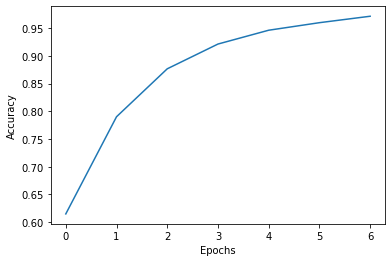

In [26]:
# PLotting accuracy of train
import matplotlib.pyplot as plt
plt.plot(model_trained.history['accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


Text(0, 0.5, 'Validation Accuracy')

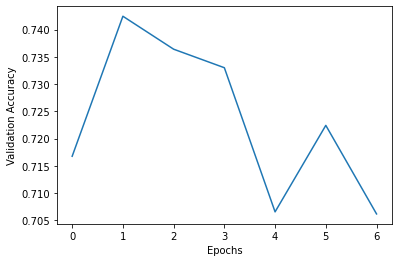

In [27]:
# PLotting accuracy of train
import matplotlib.pyplot as plt
plt.plot(model_trained.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')

In [28]:
test_sequences = tokenizer.texts_to_sequences(data_test)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.evaluate(test_padded,y_test))


27/27 [==============================] - 1s 23ms/step - loss: 0.4736 - accuracy: 0.7767
[0.4735984206199646, 0.7767441868782043]


In [29]:
from sklearn.metrics import classification_report

y_pred = model.predict(test_padded, batch_size=128, verbose=1)
y_pred = (y_pred>0.5)
print(classification_report(y_test, y_pred))

7/7 [==============================] - 1s 65ms/step
              precision    recall  f1-score   support

           0       0.61      0.56      0.58       240
           1       0.83      0.86      0.85       620

    accuracy                           0.78       860
   macro avg       0.72      0.71      0.72       860
weighted avg       0.77      0.78      0.77       860

